<a href="https://colab.research.google.com/github/ZeratulXjs/Project1_EDA/blob/main/Liz_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# to handle  data retrieval
import urllib3
from urllib3 import request

# to handle certificate verification
import certifi

# to manage json data
import json

# for pandas dataframes
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize

import os
import tempfile

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
from sklearn.metrics import precision_recall_curve
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.linear_model import LogisticRegression
import time

In [ ]:
def wrangle_data():
    http = urllib3.PoolManager(
           cert_reqs='CERT_REQUIRED',
           ca_certs=certifi.where())
    # get data from the API
    # r.status is code 200 which means everything is OK.
    url = 'https://redash.numidatech.com/api/queries/3561/results.json?api_key=haCZpJq01CeUKj46L9zFALddHeOqoK8zeH2bF4Um'
    r = http.request('GET', url)
    if r.status != 200:
        raise ValueError(f"API request failed with status {r.status}")
    data = json.loads(r.data.decode('utf-8'))
    if 'query_result' not in data or 'data' not in data['query_result'] or 'rows' not in data['query_result']['data']:
        raise ValueError("API response missing required data")
    # in this dataset, the data to extract is under 'rows'
    df = pd.json_normalize(data['query_result']['data']['rows'])
    #create column which shows whether the loan was slashed
    df['expected_monthly_income'] = (df['good_day_sales'] + df['bad_day_sales'])/2
    df['bad_to_good_day_sales'] = df['bad_day_sales']/df['good_day_sales']
    #transform data to 2 decimal places
    pd.options.display.float_format = '{:,.2f}'.format
    # #remove outliers; top 5% and bottom 5%
    # low,high = df["final_amount"].quantile([0.05,0.95])
    # mask_outliers = df["final_amount"].between(low,high)
    # df= df[mask_outliers]
    #create dataframe for model by dropping both high cardinality features and leaky features 
    df = df.drop(columns= ['id','lat','acquisition_channel','experiment','trading_license', 'district', 'lon', 'pct_due_repaid_15_dpd', 'pct_due_repaid_on_time','pct_due_repaid'] )
    return df
   

In [ ]:
df= wrangle_data()
df.head()

,region,sector_breakdown,age,num_loan_options,good_day_sales,bad_day_sales,monthly_rent,education_level,base_os_version,employee_count,years_in_operation,last_week_sales_amount,week_before_last_sales_amount,quote_amount,final_amount,paid_late,expected_monthly_income,bad_to_good_day_sales
0,Central Region,Phones Electronics,34.00,2,"500,000.00","100,000.00","1,000,000.00",A-Level,7,1.00,5.00,"300,000.00","470,000.00","260,000.00","260,000.00",False,"300,000.00",0.20
1,Eastern Region,Mobile Money Airtime,28.00,2,"15,000.00","10,000.00","35,000.00",O-Level,10,1.00,1.00,"15,000.00","20,000.00","230,000.00","200,000.00",False,"12,500.00",0.67
2,Central Region,other 12 sectors,34.00,2,"200,000.00","100,000.00","150,000.00",Tertiary,10,4.00,1.00,"500,000.00","350,000.00","260,000.00","260,000.00",False,"150,000.00",0.50
3,Western Region,Food Staple Goods,29.00,2,"700,000.00","100,000.00","300,000.00",O-Level,11,3.00,1.00,"2,200,000.00","1,950,000.00","498,000.00","300,000.00",False,"400,000.00",0.14
4,Central Region,Food Staple Goods,38.00,2,"600,000.00","100,000.00",0.00,A-Level,7,4.00,3.00,"625,000.00","482,000.00","260,000.00","260,000.00",False,"350,000.00",0.17


In [ ]:
# Check class balance on target variable; 'paid_late'
print('Paid on time',round(df['paid_late'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Paid after due date',round(df['paid_late'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Paid on time 83.32 % of the dataset
Paid after due date 16.68 % of the dataset


In [ ]:
#number of  cases
print('Paid after due date',df['paid_late'].value_counts()[1], ' are cases')
print('Paid on time',df['paid_late'].value_counts()[0], ' are cases')

Paid after due date 4694  are cases
Paid on time 23443  are cases


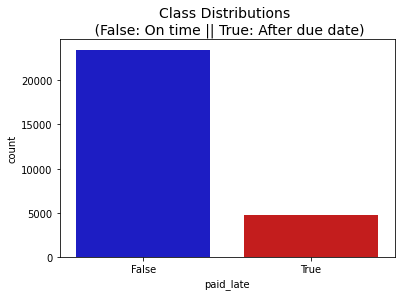

In [ ]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x='paid_late', data=df, palette=colors)
plt.title('Class Distributions \n (False: On time || True: After due date)', fontsize=14);

In [ ]:
# Identify categorical columns
cat_cols = list(df.select_dtypes(include=['object', 'category']).columns)
# Apply one-hot encoding to categorical columns
df = pd.get_dummies(df, columns=cat_cols)
df.head()

,age,num_loan_options,good_day_sales,bad_day_sales,monthly_rent,employee_count,years_in_operation,last_week_sales_amount,week_before_last_sales_amount,quote_amount,...,base_os_version_11,base_os_version_12,base_os_version_13,base_os_version_15,base_os_version_4,base_os_version_5,base_os_version_6,base_os_version_7,base_os_version_8,base_os_version_9
0,34.00,2,"500,000.00","100,000.00","1,000,000.00",1.00,5.00,"300,000.00","470,000.00","260,000.00",...,0,0,0,0,0,0,0,1,0,0
1,28.00,2,"15,000.00","10,000.00","35,000.00",1.00,1.00,"15,000.00","20,000.00","230,000.00",...,0,0,0,0,0,0,0,0,0,0
2,34.00,2,"200,000.00","100,000.00","150,000.00",4.00,1.00,"500,000.00","350,000.00","260,000.00",...,0,0,0,0,0,0,0,0,0,0
3,29.00,2,"700,000.00","100,000.00","300,000.00",3.00,1.00,"2,200,000.00","1,950,000.00","498,000.00",...,1,0,0,0,0,0,0,0,0,0
4,38.00,2,"600,000.00","100,000.00",0.00,4.00,3.00,"625,000.00","482,000.00","260,000.00",...,0,0,0,0,0,0,0,1,0,0


In [ ]:
df = pd.DataFrame(df)
df.head()

,age,num_loan_options,good_day_sales,bad_day_sales,monthly_rent,employee_count,years_in_operation,last_week_sales_amount,week_before_last_sales_amount,quote_amount,...,base_os_version_11,base_os_version_12,base_os_version_13,base_os_version_15,base_os_version_4,base_os_version_5,base_os_version_6,base_os_version_7,base_os_version_8,base_os_version_9
0,34.00,2,"500,000.00","100,000.00","1,000,000.00",1.00,5.00,"300,000.00","470,000.00","260,000.00",...,0,0,0,0,0,0,0,1,0,0
1,28.00,2,"15,000.00","10,000.00","35,000.00",1.00,1.00,"15,000.00","20,000.00","230,000.00",...,0,0,0,0,0,0,0,0,0,0
2,34.00,2,"200,000.00","100,000.00","150,000.00",4.00,1.00,"500,000.00","350,000.00","260,000.00",...,0,0,0,0,0,0,0,0,0,0
3,29.00,2,"700,000.00","100,000.00","300,000.00",3.00,1.00,"2,200,000.00","1,950,000.00","498,000.00",...,1,0,0,0,0,0,0,0,0,0
4,38.00,2,"600,000.00","100,000.00",0.00,4.00,3.00,"625,000.00","482,000.00","260,000.00",...,0,0,0,0,0,0,0,1,0,0


In [ ]:
#Split the dataset into train, validation, and test sets. 
#test set is completely unused during the training phase and is only used at the end to evaluate how well the model generalizes to new data.

cleaned_df = df.copy()
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('paid_late'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('paid_late'))
test_labels = np.array(test_df.pop('paid_late'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [ ]:
#check whether the distribution of the classes in the three sets is about the same 
print(f'Average class probability in training set:   {train_labels.mean():.4f}')
print(f'Average class probability in validation set: {val_labels.mean():.4f}')
print(f'Average class probability in test set:       {test_labels.mean():.4f}')

Average class probability in training set:   0.1668
Average class probability in validation set: 0.1677
Average class probability in test set:       0.1663


In [ ]:
#Normalize the input features using the sklearn minmax scalar.
#The minmaxScaler is only fit using the train_df to be sure the model is not peeking at the validation or test sets.

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_df = scaler.fit_transform(train_df)
test_df = scaler.transform(test_df)
val_df = scaler.transform(val_df)
print('Training df shape:', train_df.shape)
print('Validation features shape:', val_df.shape)
print('Test features shape:', test_df.shape)

Training df shape: (18007, 44)
Validation features shape: (4502, 44)
Test features shape: (5628, 44)


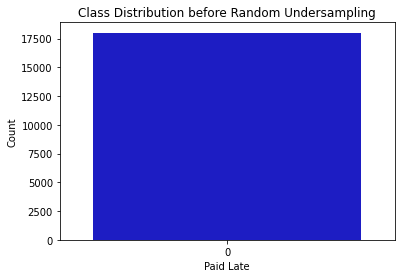

{False: 3003, True: 3003}


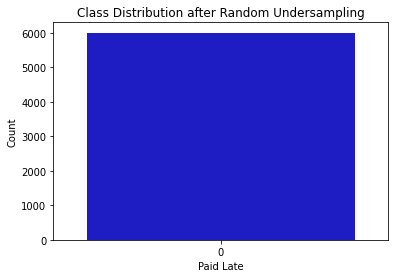

In [ ]:
#RANDOM UNDERSAMPLING by balancing the 'false' cases
# create the random undersampler with a sampling ratio of 4694 / number of 'paid_late' false cases
from imblearn.under_sampling import RandomUnderSampler
# check the class balance of the 'paid_late' target variable
sns.countplot(train_labels,palette=colors)
plt.title('Class Distribution before Random Undersampling')
plt.xlabel('Paid Late')
plt.ylabel('Count')
plt.show()

# calculate the number of 'paid_late' true cases
num_paid_late_true = np.sum(train_labels)

# create the random undersampler with a sampling ratio of 1.0 (i.e., balance the 'false' cases to equal the 'true' cases)
rus = RandomUnderSampler(sampling_strategy={False: num_paid_late_true}, random_state=42)

# fit and apply the undersampler to the training data
train_df_resampled, train_labels_resampled = rus.fit_resample(train_df, train_labels)

# check the class distribution after resampling
unique, counts = np.unique(train_labels_resampled, return_counts=True)
print(dict(zip(unique, counts)))

# plot the class balance using seaborn
sns.countplot(train_labels_resampled,palette=colors)
plt.title('Class Distribution after Random Undersampling')
plt.xlabel('Paid Late')
plt.ylabel('Count')
plt.show()

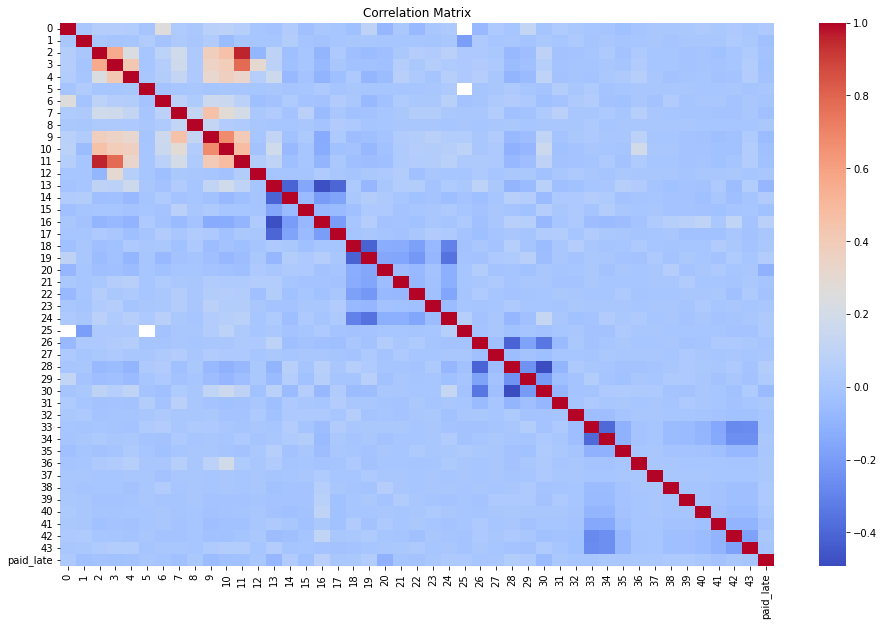

In [ ]:
# create a new DataFrame with the resampled training data
train_resampled_df = pd.DataFrame(train_df_resampled)

# add the resampled labels to the DataFrame
train_resampled_df['paid_late'] = train_labels_resampled

# create a correlation matrix using seaborn's heatmap function
f, (ax) = plt.subplots(figsize=(16,10))
corr = train_resampled_df.corr()
sns.heatmap(corr, cmap='coolwarm',annot_kws={'size':20}, ax=ax)
plt.title('Correlation Matrix')
plt.show()

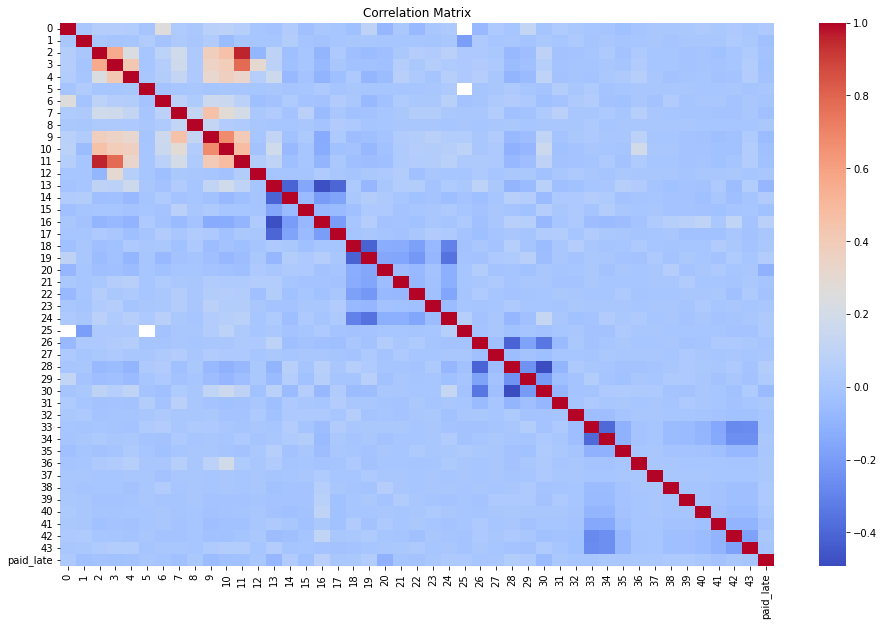

In [ ]:
# create a new DataFrame with the resampled training data
train_resampled_df = pd.DataFrame(train_df_resampled)

# add the resampled labels to the DataFrame
train_resampled_df['paid_late'] = train_labels_resampled

# get the column names
cols = train_resampled_df.columns

# create a correlation matrix using seaborn's heatmap function
f, (ax) = plt.subplots(figsize=(16,10))
corr = train_resampled_df.corr()
sns.heatmap(corr, cmap='coolwarm',annot_kws={'size':20}, ax=ax, xticklabels=cols, yticklabels=cols)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
# Separate features and target
X = train_resampled_df.drop('paid_late', axis=1)
y = train_resampled_df['paid_late']

# Impute missing values with the median value of the column
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_imputed)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_imputed)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_imputed)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 5.5e+01 s
PCA took 0.058 s
Truncated SVD took 0.041 s


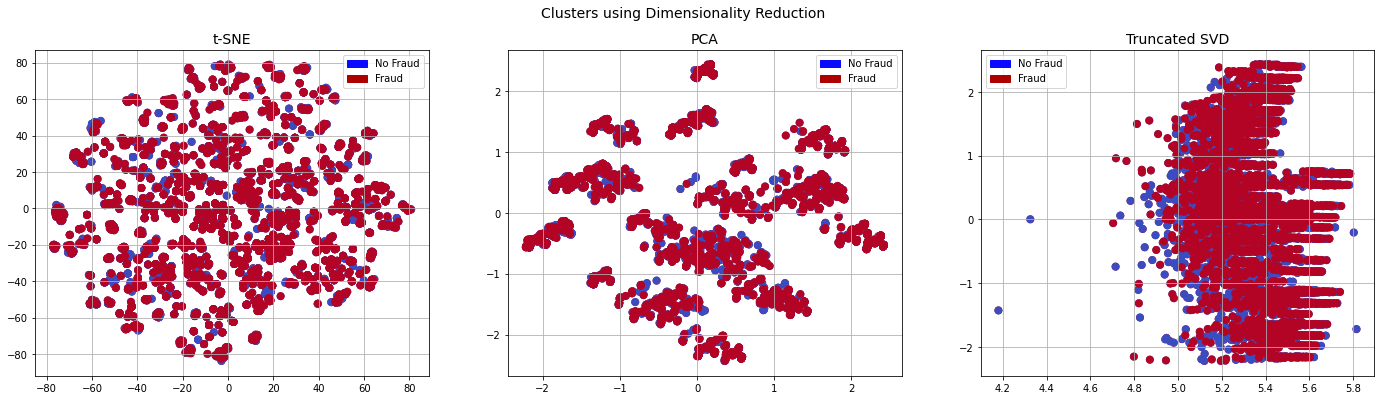

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [ ]:
# Classifiers (UnderSampling): training 4 classifiers i.e logistic regression, gridsearchCV, 
# Undersampling before cross validating (prone to overfit)
X = train_resampled_df.drop('paid_late', axis=1)
y = train_resampled_df['paid_late']

# split the data for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Fill in any missing values in X_train and X_test
imputer = SimpleImputer()
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# implement simple classifiers

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier()
}

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

Classifiers:  LogisticRegression Has a training score of 54.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 53.0 % accuracy score
Classifiers:  SVC Has a training score of 54.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 51.0 % accuracy score
